In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import sys, pickle

In [2]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential

In [3]:
#FUNCTIONS

#mean, median, and std of dataset columns
def get_stats(df):
    
    df = np.array(df)
    stats = []
    
    for i in range(df.shape[0]):
        mean = np.mean(df[i])
        median = np.median(df[i])
        std = np.std(df[i])
        stats.append([mean, median, std])
        
    stats = pd.DataFrame(stats)
    
    return stats


#opens the file of a dataset with the RMSE
def extract_error(dataset, alphas):
    df = []
    for alpha in alphas:
        result = np.loadtxt('data/' + dataset + '/results/' + dataset + 
                             '_test_error_alpha' + alpha + '.txt')
        df.append(result)
    result = np.loadtxt('data/' + dataset + '/results/' + dataset + '_test_nn_rmse.txt')
    df.append(result)
    return df


#opens the file of a dataset with the -log likelihood
def extract_ll(dataset, alphas):
    df = []
    for alpha in alphas:
        result = np.loadtxt('data/' + dataset + '/results/' + dataset + 
                             '_test_ll_alpha' + alpha + '.txt')
        df.append(result)
    return df


#creates a boxplot
def box_plot(df, dataset, title):
    
    if title == 'Test RMSE':
        labels = ['-Inf', '0', '0.5', '1', 'Inf', 'NN']
    else:
        labels = ['-Inf', '0', '0.5', '1', 'Inf']
    
    fig, ax = plt.subplots(figsize=(5, 5))
    bplot = ax.boxplot(df,
                     showmeans = True,
                     notch=False,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels, # will be used to label x-ticks
                     showfliers=False)  # hide outliers
    ax.set_title(title + ' (' + dataset + ')')

    # fill with colors
    colors = ['whitesmoke', 'lightgrey','silver', 'darkgrey', 'grey']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # adding horizontal grid lines
    ax.yaxis.grid(True)
    ax.set_xlabel('Alpha')

    plt.show()
    
    return None


#normalize data
def norm(x, train_stats):
  return (x - train_stats['mean']) / train_stats['std']


#creates neural net model
def build_model(train_dataset):
  model = keras.Sequential([
    layers.Dense(50, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False,
    name='Adam')

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


#fits the model and returns an array with the RMSE for each split of the data
def fit_neural_net(dataset, n_splits):

    # We load the data
    dataset_path = 'data/' + dataset + '/data.txt'
    raw_dataset = pd.DataFrame(np.loadtxt(dataset_path))
    df = raw_dataset.copy()
        
    index_target = np.loadtxt('data/' + dataset + '/index_target.txt')
    i_target = int(index_target)

    #iterate over the number of splits
    for i in range(n_splits):
        np.random.seed(i)
        train_dataset = df.sample(frac=0.9,random_state=0)
        test_dataset = df.drop(train_dataset.index)

        train_stats = train_dataset.describe()
        train_stats.pop(i_target)
        train_stats = train_stats.transpose()
    
        train_labels = train_dataset.pop(i_target)
        test_labels = test_dataset.pop(i_target)
        
        normed_train_data = norm(train_dataset, train_stats)
        normed_test_data = norm(test_dataset, train_stats)

        model = build_model(train_dataset)

        EPOCHS = 500

        history = model.fit(
          normed_train_data, train_labels,
          epochs=EPOCHS, validation_split = 0.2, verbose=0)

        test_predictions = model.predict(normed_test_data).flatten()

        rmse = np.sqrt(np.mean((test_labels - test_predictions)**2))

        with open('data/' + dataset + '/' + 'results/' + dataset + "_test_nn_rmse.txt", 'a') as f: 
            f.write(repr(rmse) + '\n')
    
    return None

In [10]:
datasets = ['boston', 'computer', 'concrete', 'energy', 'housing',
            'power', 'slump', 'wine', 'yacht']

alphas = ['-inf', '0', '0.5', '1', '100000']

all_data = {}

In [9]:
#gets the error and -ll for a regular neural net for all datasets
#(this takes a long time to run)
for dataset in datasets:
    fit_neural_net(dataset, n_splits = 10)

In [11]:
#gathers all data in one dictionary
for dataset in datasets:
    error_data = extract_error(dataset, alphas)
    ll_data = extract_ll(dataset, alphas)
    all_data.update({dataset + '_error':error_data})
    all_data.update({dataset + '_ll':ll_data})

In [14]:
for dataset in datasets:
    error_stats = get_stats(all_data[dataset + '_error'])
    ll_stats = get_stats(all_data[dataset + '_ll'])
    print(dataset + ' error:')
    print(error_stats.transpose())
    print(dataset + ' negative log likelihood:')
    print(ll_stats.transpose())

boston error:
          0         1         2         3         4         5
0  2.558753  2.546246  2.549237  2.568746  2.448028  2.806323
1  2.540577  2.469461  2.485510  2.513175  2.342259  2.796231
2  0.224727  0.197537  0.321130  0.276913  0.231368  0.192632
boston negative log likelihood:
          0         1         2         3         4
0  2.328724  2.321372  2.328342  2.464244  2.395386
1  2.315293  2.306733  2.306040  2.463132  2.383160
2  0.097435  0.084938  0.098573  0.036017  0.036493
computer error:
           0          1          2          3          4          5
0  13.098905  12.744249  12.838623  11.313958  12.357204  80.744233
1   9.545764   8.452012  11.180288   6.897408   6.243001  80.700098
2  12.252314  11.793216  11.712946  11.498969  13.702698  18.141944
computer negative log likelihood:
          0         1         2         3         4
0  4.549889  4.551880  4.545934  4.544129  4.616226
1  4.553751  4.540650  4.536404  4.534453  4.592146
2  0.035914  0.04230

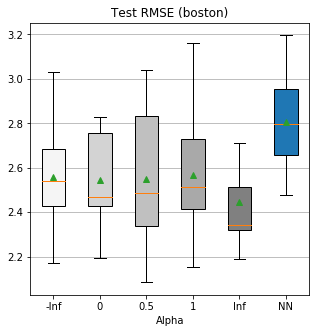

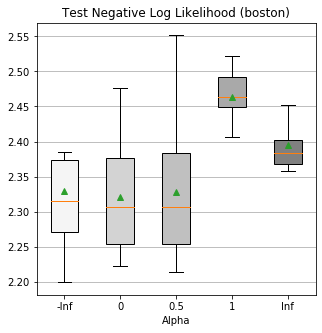

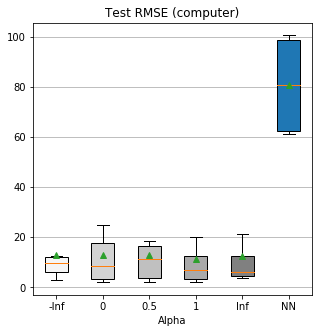

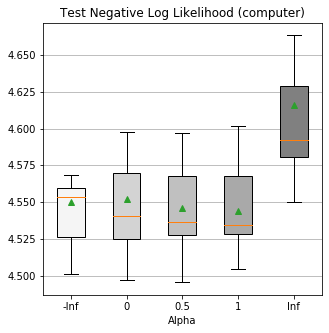

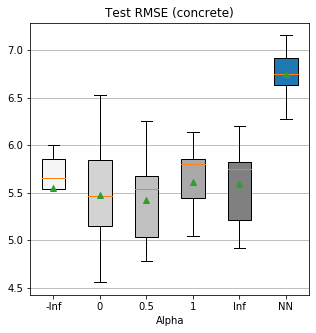

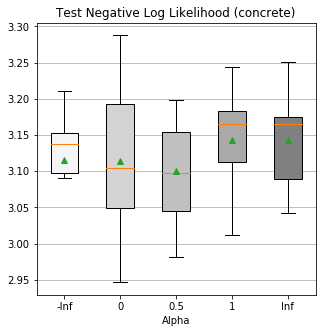

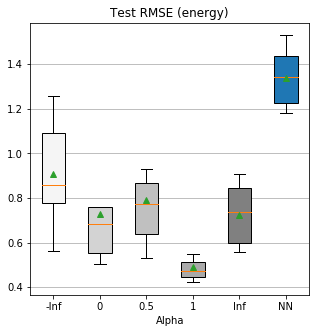

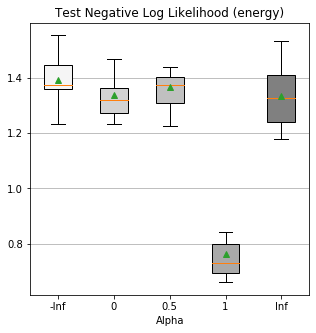

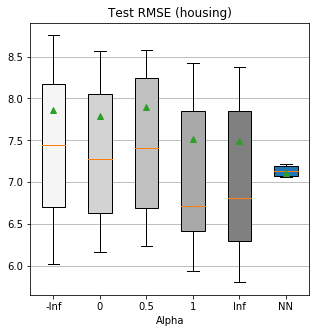

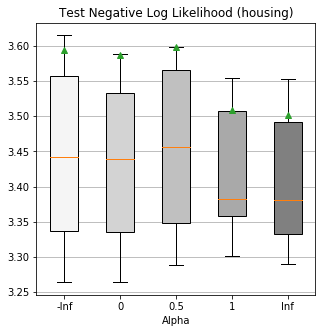

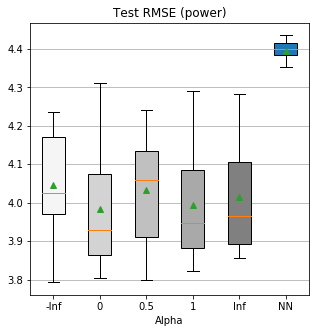

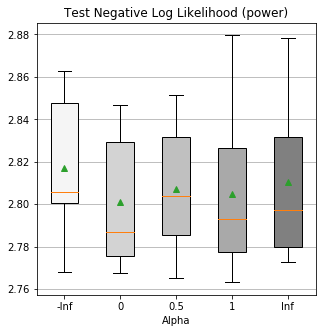

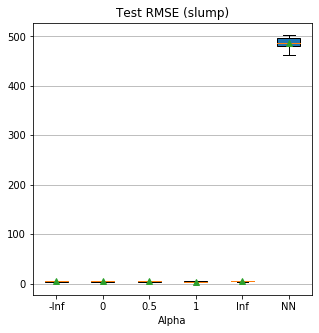

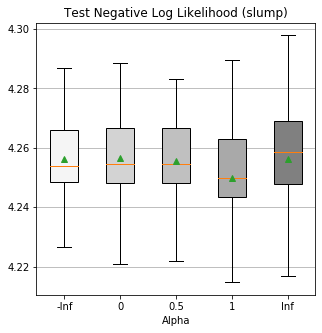

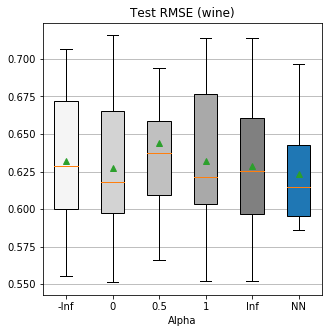

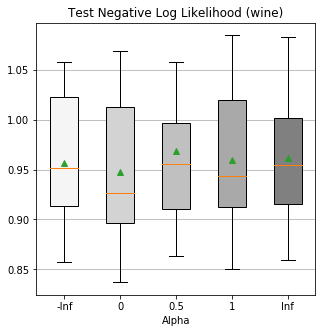

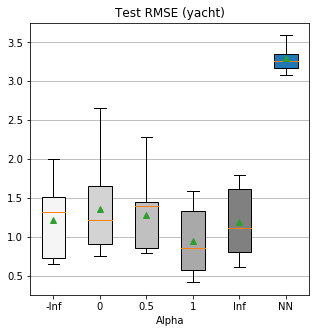

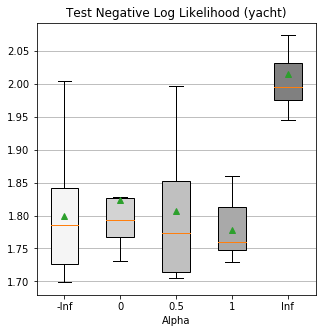

In [13]:
#make all the plots
for dataset in datasets:
    error = all_data[dataset + '_error']
    ll = all_data[dataset + '_ll']
    box_plot(error, dataset, title = 'Test RMSE')
    box_plot(ll, dataset, title = 'Test Negative Log Likelihood')